In [306]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import pickle as pkl

import os
# os.chdir(r'E:\workspace\ai\ml_utils\proj\RRVF')
os.chdir(r'/Users/kevindu/Documents/workspace/ml_utils/proj/RRVF')
import glob
import re
import pickle

import numpy as np
import pandas as pd
from isoweek import Week
from pandas_summary import DataFrameSummary
from keras.models import model_from_yaml
import utils
# import xgboost
import random
from importlib import reload
reload(utils)
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Create Model

In [47]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))

hol = pd.read_csv('{}/date_info.csv'.format(data_dir))
hol = hol.rename(
    {
        'calendar_date': 'Date',
    }, axis='columns')
hol.Date = pd.to_datetime(hol.Date)
hol = utils.add_ts_elapsed('holiday_flg', ['dur_'], hol)
calender = hol[['Date', 'holiday_flg', 'dur_holiday_flg']]
prophit_hol = calender[calender.holiday_flg == 1].rename({
    'dur_holiday_flg': 'holiday',
    'Date': 'ds'
},axis="columns").drop('holiday_flg', axis=1)
prophit_hol.holiday = prophit_hol.holiday.astype('str')

model_zoo = {}
def trn2prop(trn):
    prop = trn.drop('air_store_id', axis=1).rename({
        'visit_date': 'ds',
        'visitors': 'y'
    },axis="columns")
    prop.y = np.log(prop['y'])
    return prop


def fit_func(trn):
    model_key = trn.air_store_id.unique().tolist()[0]
    prop = trn2prop(trn)
    model_zoo[model_key] = None
    m = Prophet(holidays=prophit_hol, yearly_seasonality=False, daily_seasonality=False)
    m.fit(prop)
    model_zoo[model_key] = m
    return None

trn.groupby('air_store_id').apply(fit_func)
pkl.dump(model_zoo, open('result/prop.pkl','wb'))
# result = pkl.load(open('result/result1.pkl', 'rb'))

# Submision


In [173]:
data_dir = r'./data'
tst = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(tst)
trn_like_test = trn_like_test.assign(visitors=0)

In [179]:
ids = trn_like_test.air_store_id.unique().tolist()
for a_store_id in ids:
    trn_like_test.loc[trn_like_test['air_store_id'] == a_store_id, 'visitors' ] = result[a_store_id].values

In [178]:
len(trn_like_test.loc[trn_like_test['air_store_id'] == 'air_fff68b929994bfbd' ])

39

In [193]:
tst['visitors'] = trn_like_test.visitors

In [196]:
tst.to_csv('result/prop.csv', index=False)

In [189]:
trn_like_test.head()

,air_store_id,visit_date,visitors
0,air_00a91d42b08b08d9,2017-04-23,2.200475
1,air_00a91d42b08b08d9,2017-04-24,22.637175
2,air_00a91d42b08b08d9,2017-04-25,24.656827
3,air_00a91d42b08b08d9,2017-04-26,30.577091
4,air_00a91d42b08b08d9,2017-04-27,32.924348


# Merge timeseris features with trn

In [311]:
data_dir = r'./data'
trn = pd.read_csv('{}/air_visit_data.csv'.format(data_dir))
ts_feat = pkl.load(open('data/ts_prep.pkl', 'rb'))

In [314]:
ts_feat['air_07b314d83059c4d2'].tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,1,1_lower,1_upper,2,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
513,2017-05-28,3.674103,3.650671,3.696629,3.676325,4.395115,0.0,0.0,0.0,0.0,...,0.372978,0.372978,0.372978,0.372978,0.372978,0.372978,0.372978,0.372978,0.372978,4.047081
514,2017-05-29,3.674944,3.650572,3.698598,3.044828,3.744352,0.0,0.0,0.0,0.0,...,-0.254107,-0.254107,-0.254107,-0.254107,-0.254107,-0.254107,-0.254107,-0.254107,-0.254107,3.420837
515,2017-05-30,3.675786,3.650527,3.700483,3.042383,3.752069,0.0,0.0,0.0,0.0,...,-0.275253,-0.275253,-0.275253,-0.275253,-0.275253,-0.275253,-0.275253,-0.275253,-0.275253,3.400532
516,2017-05-31,3.676627,3.650313,3.702388,3.265323,3.961059,0.0,0.0,0.0,0.0,...,-0.071783,-0.071783,-0.071783,-0.071783,-0.071783,-0.071783,-0.071783,-0.071783,-0.071783,3.604844
517,2017-06-01,3.677468,3.649643,3.704124,3.147645,3.904876,0.0,0.0,0.0,0.0,...,-0.130505,-0.130505,-0.130505,-0.130505,-0.130505,-0.130505,-0.130505,-0.130505,-0.130505,3.546964


In [315]:
en_trn = utils.add_prop(trn, ts_feat)

In [317]:
tst = pd.read_csv('{}/sample_submission.csv'.format(data_dir))
trn_like_test = utils.tes2trn(tst)
trn_like_test = trn_like_test.assign(visitors=0)

In [318]:
en_tst = utils.add_prop(trn_like_test, ts_feat)

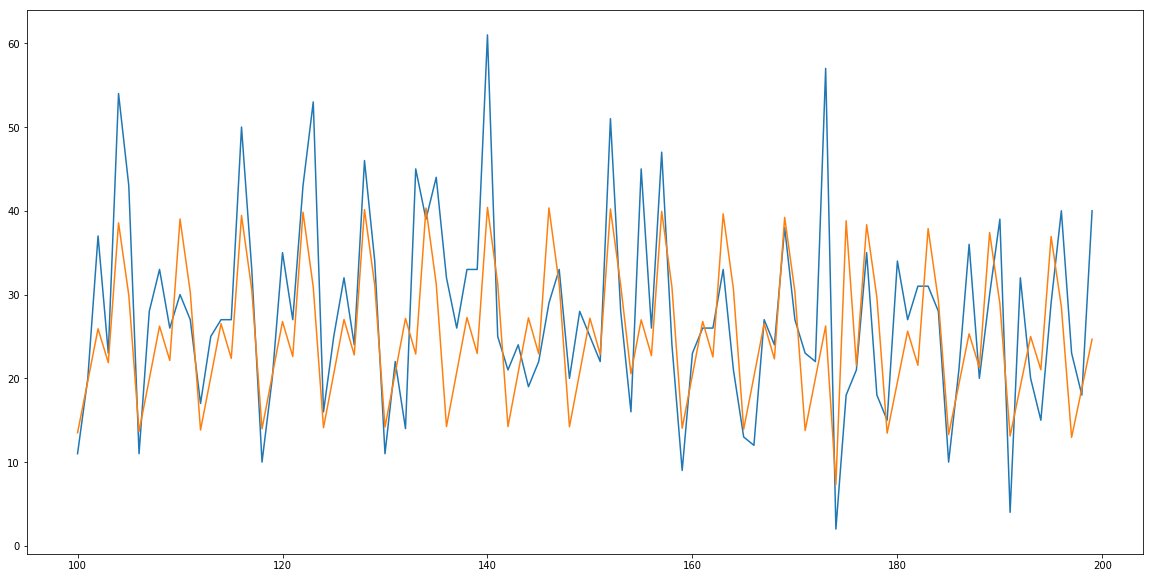

In [279]:
a =slice(100,200,1)
plt.plot(a_store_df.visitors[a])
plt.plot(np.exp(a_store_df.prop_yhat[a]))